In [1]:
%matplotlib qt

# Short ERP Analysis from OpenVibe data converted to gdf
Data was converted to gdf using openvibe-convert.cmd
- First step is to rename and filter the annotations from openvibe
- translate the annotations into markers
- create epochs
- process epochs
- plot ERP
- (?) a bit of statistics

In [2]:
import matplotlib
import numpy as np
#%matplotlib ipympl
import os
import mne
import itertools

In [3]:
# remove me
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf, read_raw_brainvision
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [4]:
apply_CSD = True  # use Current Source Density (spatial filter)
apply_ASR = False  # use Artifact Subspace Reconstruction (artifact removal)

In [5]:
data_dir=r"C:\BCI\dev\p300_analysis_from_openvibe"
os.path.exists(data_dir)
fnames = []
for file in os.listdir(data_dir):
    if file.endswith(".gdf"):
        fnames.append(os.path.join(data_dir, file))
        print(os.path.join(data_dir, file))

C:\BCI\dev\p300_analysis_from_openvibe\data_calib-019-2021-06-10_12_27_24.gdf


### Load gdf files

In [6]:
# load and preprocess data ####################################################
raws = [mne.io.read_raw_gdf(f, preload=True) for f in [fnames[0]]]
#raw = concatenate_raws(raws)
raw = raws[0]

Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\data_calib-019-2021-06-10_12_27_24.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 38583  =      0.000 ...    75.357 secs...


<ipython-input-6-d0f71234aaee>:2: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in [fnames[0]]]


In [7]:
raw.info['ch_names']

['Channel 1',
 'Channel 2',
 'Channel 3',
 'Channel 4',
 'Channel 5',
 'Channel 6',
 'Channel 7',
 'Channel 8']

### Todo: rereference

In [8]:
# define channel names
cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
if len(raw.info['ch_names'])>8:
    cname.extend(["ch{}".format(i) for i in range(9,16+1)])
print(cname)
cname_map = dict(zip(raw.info['ch_names'], cname))
# define channel types
types = list(itertools.repeat('eeg', 8))
if len(raw.info['ch_names'])>8:
    types.extend(list(itertools.repeat('misc', 8)))
type_map = dict(zip(cname, types))

# rename and pick eeg
raw.rename_channels(cname_map, allow_duplicates=False)
raw.set_channel_types(type_map)
raw.pick_types(eeg=True, misc=False)


['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']


<RawGDF | data_calib-019-2021-06-10_12_27_24.gdf, 8 x 38584 (75.4 s), ~2.4 MB, data loaded>

Set the 10-05 montage defining electrode positions. This will allow topoplots and CSD processing to be made

In [9]:
montage = mne.channels.make_standard_montage('standard_1005')
raw = raw.set_montage(montage, match_case=False) 

## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

In [10]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 sec)



<RawGDF | data_calib-019-2021-06-10_12_27_24.gdf, 8 x 38584 (75.4 s), ~2.4 MB, data loaded>

Plot the filtered signal

In [11]:
raw.plot()
apply_CSD

True

## Apply current source density

In [12]:
if apply_CSD:
    raw_csd = mne.preprocessing.compute_current_source_density(raw)
    raw = raw_csd
    raw_csd.plot()


Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.9 5.9 51.9 mm
Origin device coordinates:    0.9 5.9 51.9 mm


<ipython-input-12-b3035c12c9a8>:2: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  raw_csd = mne.preprocessing.compute_current_source_density(raw)


In [13]:
# dont forget to apply the transformation


## Artifact Subspace Reconstruction fitting and reconstruction

In [14]:
if apply_ASR:
    #!pip install meegkit pymanopt
    from meegkit.asr import ASR
    fs = int(raw.info["sfreq"])  # sampling frequency
    method='riemann'  # if error, use 'euclid' -> actually the case
    window_s=.5  # .5 sec window of analysis
    data_interval_s  = None # (begin, end) in sec of the training sample
    estimator='lwf'  #leave blank if using euclidian mode 

    # define the ASR model using riemannian method
    #asr_model = ASR(sfreq=fs, method=method, win_len=window_s, estimator=estimator)

    # if failing (after trying twice. SVD error occurs for no reason sometimes)
    asr_model = ASR(sfreq=fs, method="euclid", win_len=window_s)

    # The best would be to choose another recording during the same session to train the model without overfitting
    data = raw._data  # the numpy array with data is stored in the _data variable

    # Select a time interval for training data
    train_idx = None
    if data_interval_s is not None:
        train_idx = np.arange(data_interval_s[0] * fs, data_interval_s[1] * fs, dtype=int)
    # otherwise select the whole training set
    else:
        train_idx = np.arange(0, data.shape[1])

    train_data = data[:, train_idx]
    print('Training on samples of size {}'.format(train_data.shape))

    # fir the ASR model with data intervals
    _, sample_mask = asr_model.fit(train_data)
    print('Model trained')


### Clean the current dataset
Please check whether using this artifact filtering method increases signal to noise ratio rather than reducing it

In [15]:
if apply_ASR:
    clean =  asr_model.transform(raw._data)

    display_asr_results = True
    display_window_s = 15  # 

    if display_asr_results:  #
        data_p = raw._data[0:fs*display_window_s]  # reshape to (n_chans, n_times)
        clean_p = clean[0:fs*display_window_s]

        ###############################################################################
        # Plot the results
        # -----------------------------------------------------------------------------
        #
        # Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
        # The algorithm then removes portions of this data with high amplitude
        # artifacts before running the calibration (hatched area = good).
        nb_ch_disp = 5
        times = np.arange(data_p.shape[-1]) / fs
        f, ax = plt.subplots(nb_ch_disp, sharex=True, figsize=(32, 16))
        for i in range(nb_ch_disp):
            # ax[i].fill_between(train_idx / fs, 0, 1, color='grey', alpha=.3,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   label='calibration window')
            # ax[i].fill_between(train_idx / fs, 0, 1, where=sample_mask.flat,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   facecolor='none', hatch='...', edgecolor='k',
            #                   label='selected window')
            ax[i].plot(times, data_p[i], lw=.5, label='before ASR')
            ax[i].plot(times, clean_p[i], label='after ASR', lw=.5)
            # ax[i].plot(times, raw[i]-clean[i], label='Diff', lw=.5)
            # ax[i].set_ylim([-50, 50])
            ax[i].set_ylabel(f'ch{i}')
            ax[i].set_yticks([])
        ax[i].set_xlabel('Time (s)')
        ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.subplots_adjust(hspace=0, right=0.75)
        plt.suptitle('Before/after ASR')
        plt.show()
    raw.data_ = clean

Dont forget to use the cleaned data

### Convert text annotations (i.e. unprocessed events) into events

Lets have a look at the annotations

In [16]:
import pprint
print(raw.annotations.to_data_frame())
df = raw.annotations.to_data_frame()
print('Displaying all annotations')
annot_codes = [np.int64(n) for n in np.unique(df['description'])]
annot_codes

                         onset  duration description
0   1970-01-01 00:00:13.320312  0.001953           0
1   1970-01-01 00:00:13.326172  0.001953       32773
2   1970-01-01 00:00:13.326172  0.001953       33033
3   1970-01-01 00:00:13.326172  0.001953       33286
4   1970-01-01 00:00:13.382812  0.001953       32779
..                         ...       ...         ...
845 1970-01-01 00:01:12.652344  0.001953       32780
846 1970-01-01 00:01:12.652344  0.001953       33029
847 1970-01-01 00:01:12.652344  0.001953       33286
848 1970-01-01 00:01:12.714844  0.001953       32779
849 1970-01-01 00:01:12.847656  0.001953       32780

[850 rows x 3 columns]
Displaying all annotations


[0,
 32773,
 32774,
 32779,
 32780,
 33025,
 33026,
 33027,
 33028,
 33029,
 33030,
 33031,
 33032,
 33033,
 33034,
 33035,
 33036,
 33037,
 33038,
 33285,
 33286]

These annotations seem to relate to hex codes. OpenViBE definitions can be found on [OpenViBE's website](http://openvibe.inria.fr/stimulation-codes/). Let's parse the copypasted list

In [17]:
import re
tr_sim= ''
pat_extract= re.compile('^([^ ]+)[ ]+0x[0-9A-Fa-f]+[ \/]+([0-9]+)')
#OVTK_GDF_125_Watt                                     0x585       //  1413
k_stim = []
k_stim_int = []
v_stim = []

# read and convert annotations
with open(r'.\ov_stims.txt', 'r') as fd:
    for line in fd.readlines():
        m = pat_extract.match(line)
        v, k = m.groups()
        k_stim.append(k)
        k_stim_int.append(int(k))
        v_stim.append(v)

# format dict and list
stim_map = dict(zip(k_stim_int, v_stim))
stim_map_inv = dict(zip(v_stim, k_stim))

stim_tup = list(zip(k_stim_int, v_stim))

Make a dataframe of the stimuli in common between both

In [18]:
import pandas as pd
df = pd.DataFrame.from_dict(stim_tup)
df.columns = ['coden', 'desc']
df[[c in annot_codes for c in df.coden]]

,coden,desc
125,33025,OVTK_StimulationId_Label_01
126,33026,OVTK_StimulationId_Label_02
127,33027,OVTK_StimulationId_Label_03
128,33028,OVTK_StimulationId_Label_04
129,33029,OVTK_StimulationId_Label_05
130,33030,OVTK_StimulationId_Label_06
131,33031,OVTK_StimulationId_Label_07
132,33032,OVTK_StimulationId_Label_08
133,33033,OVTK_StimulationId_Label_09
134,33034,OVTK_StimulationId_Label_0A


From this table, lets locate and save the codes for Target and Non-Target and give them the following values: target=1 and non-target=0 

In [19]:
target_map = {'33286':0, '33285':1}

Then we can convert annotations into events

In [20]:
events, _ = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(events[:])))

Used Annotations descriptions: ['33285', '33286']
Found 210 events


### Choose the channels to analyze

In [21]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

### Create epochs for each class

In [22]:
event_ids = dict(NonTarget=0, Target=1) 
epochs = mne.Epochs(raw, events, event_id=event_ids, tmin=-0.5, tmax=0.6,
                    preload=True)
fig = epochs.plot()

Not setting metadata
Not setting metadata
210 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 210 events and 564 original time points ...
0 bad epochs dropped


### todo: reject some events


In [23]:
if False:
    reject_criteria = dict(eeg=100e-6,  # 100 µV
                       eog=200e-6)  # 200 µV
    _ = epochs.drop_bad(reject=reject_criteria)
    epochs.plot_drop_log()

### Average the epochs of each class

In [24]:
l_nt = epochs['NonTarget'].average()
l_target = epochs['Target'].average()

In [25]:
fig1 = l_target.plot(spatial_colors=True)
fig2 = l_nt.plot(spatial_colors=True)

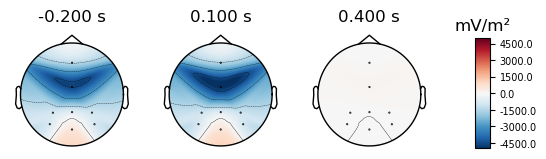

In [26]:
l_target.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05)

No projector specified for this dataset. Please consider the method self.add_proj.


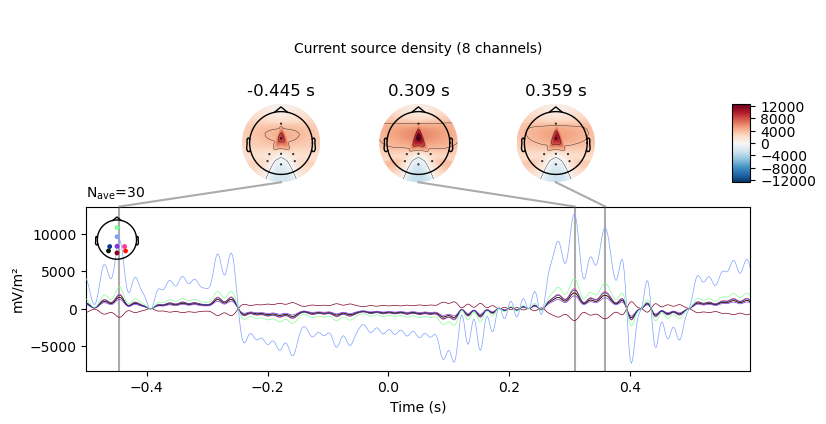

In [27]:
l_target.plot_joint()

### Compare conditions

In [28]:
l_target

<Evoked | 'Target' (average, N=30), -0.5 – 0.59961 sec, baseline -0.5 – 0 sec, 8 ch, ~53 kB>

In [29]:
evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
#picks = [f'eeg{n}' for n in range(10, 15)]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

Dropped 0 epochs: 
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none


### Same but with CI

In [30]:
evokeds = dict(NonTarget=l_nt.iter_evoked(), Target=l_target.iter_evoked())
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

AttributeError: 'EvokedArray' object has no attribute 'iter_evoked'

In [31]:
### Difference Target vs Non-Target

No projector specified for this dataset. Please consider the method self.add_proj.


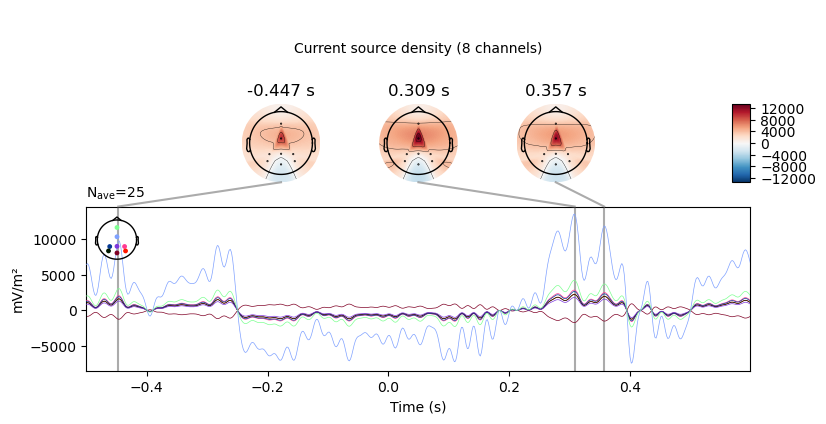

In [32]:
diff_vis = mne.combine_evoked([l_target, l_nt], weights=[1, -1])
diff_vis.plot_joint()

In [33]:
epochs_balanced, _ = epochs.equalize_event_counts(event_ids=event_ids, method='mintime')
epochs_balanced

Dropped 150 epochs: 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 181, 182, 183, 184, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 206, 207, 208, 209


Number of events,60
Events,NonTarget: 30Target: 30
Time range,-0.500 – 0.600 sec
Baseline,-0.500 – 0.000 sec


No projector specified for this dataset. Please consider the method self.add_proj.


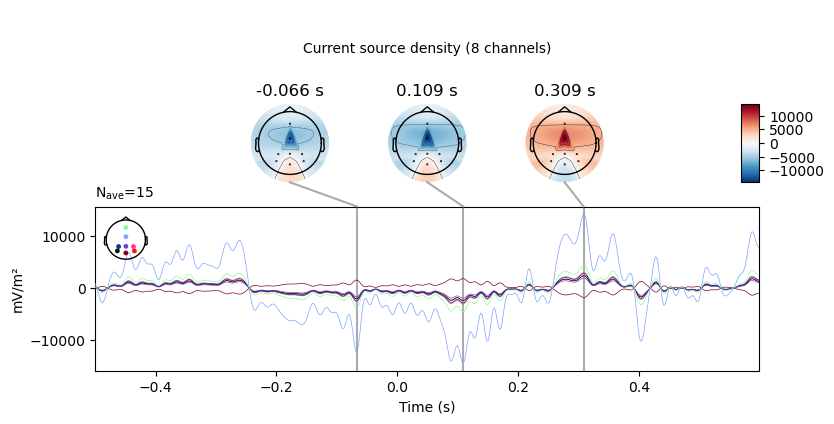

In [34]:
l_nt_balanced = epochs_balanced['NonTarget'].average()
l_target_balanced = epochs_balanced['Target'].average()
diff_vis = mne.combine_evoked([l_target_balanced, l_nt_balanced], weights=[1, -1])
diff_vis.plot_joint()

In [35]:
mne.stats.permutation_t_test()

TypeError: permutation_t_test() missing 1 required positional argument: 'X'

In [57]:
print(epochs['NonTarget']._data.shape)
m_nt = epochs['NonTarget']._data[:,1,...]
m_t = epochs['Target']._data[:,1,...]

(30, 8, 564)


In [45]:
l_nt.data.shape

(8, 564)

In [91]:
tmin, tmax = -1, 4  # define epochs around events (in s)
event_ids = dict(NonTarget=0, Target=1) 

### Define a function to display ERD/ERS that are significant based on a permutation test (mne example available here https://mne.tools/dev/auto_examples/time_frequency/plot_time_frequency_erds.html?highlight=erd )

In [92]:
def compute_significant_ERDS_maps(raw: mne.io.Raw, event_ids: dict, mask_p_val=.05):
    compute_masks = mask_p_val < 1
    print("Computing clusters p vaues {}".format(compute_masks))
    
    epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                        picks=picks, baseline=None, preload=True)
    
    # compute ERDS maps ###########################################################
    freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
    n_cycles = freqs  # use constant t/f resolution
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = [-1, 0]  # baseline interval (in s)
    cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
    cmap = center_cmap(plt.cm.bwr, vmin, vmax)  # zero maps to white
    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')  # for cluster test

    # Run TF decomposition overall epochs
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                         use_fft=True, return_itc=False, average=False,
                         decim=2)
    tfr.crop(tmin, tmax)
    tfr.apply_baseline(baseline, mode="percent")
    for event in event_ids:
        print('Processing {}'.format(event))
        # select desired epochs for visualization
        tfr_ev = tfr[event]
        fig, axes = plt.subplots(1, 8, figsize=(12, 4),
                                 gridspec_kw={"width_ratios": [10, 10, 10, 10, 10, 10, 10, 1]})
        for ch, ax in enumerate(axes[:-1]):  # for each channel
            
            if compute_masks:
                # positive clusters
                _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
                # negative clusters
                _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                             **kwargs)

                # note that we keep clusters with p <= 0.05 from the combined clusters
                # of two independent tests; in this example, we do not correct for
                # these two comparisons
                c = np.stack(c1 + c2, axis=2)  # combined clusters
                p = np.concatenate((p1, p2))  # combined p-values
                mask = c[..., p <= mask_p_val].any(axis=-1)

                # plot TFR (ERDS map with masking)
                tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                                      axes=ax, colorbar=False, show=False, mask=mask,
                                      mask_style="mask")
            else:
                tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                      axes=ax, colorbar=False, show=False)

            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        #fig.colorbar(axes[0].images[-1], cax=axes[-1])
        fig.suptitle("ERDS ({})".format(event))
        fig.show()
    return tfr, epochs.ch_names

In [93]:
import itertools

def compute_pairwise_ERDS_maps(raw: mne.io.Raw, event_ids: dict):

    epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                        picks=picks, baseline=None, preload=True)
    
    # compute ERDS maps ###########################################################
    freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
    n_cycles = freqs  # use constant t/f resolution
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = [-1, 0]  # baseline interval (in s)
    cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
    cmap = center_cmap(plt.cm.bwr, vmin, vmax)  # zero maps to white
    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')  # for cluster test

    # Run TF decomposition overall epochs
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                         use_fft=True, return_itc=False, average=False,
                         decim=8)
    tfr.crop(tmin, tmax)
    # tfr.apply_baseline(baseline, mode="percent") for comparison, baseline in absolute power
    #tfr.apply_baseline(baseline, mode="mean") 
    pairs = list(itertools.combinations(event_ids, 2))
    for pair in pairs:
        evt1, evt2 = pair 

        print('Processing pair {}'.format(pair))
        # select desired epochs for visualization
        tfr.apply_baseline(baseline, mode="mean") 
        tfr_ev1 = tfr[evt1]
        
        tfr_ev2 = tfr[evt2]
        #tfr_ev2.apply_baseline(baseline, mode="mean") 
        
        tfr_diff= tfr_ev1.average() - tfr_ev2.average() #tfr_ev1.average() - tfr_ev2.average()
        #tfr_diff.apply_baseline(baseline, mode="percent") 
        #vmin = -1
        #vmax = 1
        tfr_diff.apply_baseline(baseline, mode="logratio") 
        
        fig, axes = plt.subplots(1, 8, figsize=(12, 4),
                                 gridspec_kw={"width_ratios": [10, 10, 10, 10, 10, 10, 10, 1]})
        for ch, ax in enumerate(axes[:-1]):  # for each channel

            #tfr_diff.plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
            #      axes=ax, colorbar=False, show=False)
            tfr_diff.plot([ch], axes=ax, colorbar=False, show=False)
            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        fig.colorbar(axes[0].images[-1], cax=axes[-1])
        fig.suptitle("ERDS ({})".format(pair))
        fig.show()
    return tfr_diff, epochs.ch_names

In [94]:
tfr_diff, chnames = compute_pairwise_ERDS_maps(raw, event_ids)

Not setting metadata
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Loading data for 210 events and 3073 original time points ...
10 bad epochs dropped
Not setting metadata
Processing pair ('NonTarget', 'Target')
Applying baseline correction (mode: mean)
Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Anaconda3\envs\p300mne\lib\site-packages\mne\baseline.py:103: RuntimeWarning: divide by zero encountered in true_divide
  d /= m
C:\Anaconda3\envs\p300mne\lib\site-packages\mne\baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


No baseline correction applied


# Display results ERD ERS

sometimes errors occur for no reason when using `compute_significant_ERDS_maps()`, try to execute several times using CTRL+ENTER until it executes

### Plots no significance test

In [95]:
event_ids = dict(lh=1,rh=2,feet=3,rest=4)  # map event IDs to tasks
event_ids = dict(lh=1,rh=2,rest=4)  # map event IDs to tasks
tfr, chnames = compute_significant_ERDS_maps(raw, event_ids, mask_p_val=1)

#compute_significant_ERDS_maps(raw, event_ids)

Computing clusters p vaues False


ValueError: No matching events found for rh (event id 2)

### Plots with significance

In [ ]:
compute_significant_ERDS_maps(raw, event_ids, mask_p_val=.05)
#compute_significant_ERDS_maps(raw, event_ids)

In [ ]:
# plt.plot(tfr[event_ids['lh']])
event_ids = dict(lh=1)  # map event IDs to tasks
epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)

# compute ERDS maps ###########################################################
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
cmap = center_cmap(plt.cm.bwr, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

# Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,
                     decim=2)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")


# extract left hand epochs
vmin, vmax = -2, 2  # set min and max ERDS values in plot
cmap = center_cmap(plt.cm.bwr, vmin, vmax)  # zero maps to white
fig, axes = plt.subplots(1, 8, figsize=(12, 4),
                         gridspec_kw={"width_ratios": [10, 10, 10, 10, 10, 10, 10, 1]})

for event in event_ids:
    print('Processing {}'.format(event))
    # select desired epochs for visualization
    tfr_ev = tfr[event]

    for ch, ax in enumerate(axes[:-1]): 
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                  axes=ax, colorbar=False, show=False)

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        tfr_ev[1].average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False)
        ax.set_title(epc.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")

fig.colorbar(axes[0].images[-1], cax=axes[-1])
fig.show()